This notebook replicates the experiments suggested in the paper "Distributed Representation of n-gram Statistics for Boosting Self-organizing Maps with Hyperdimensional Computing" (2019) - Available at https://t.ly/_m2aa

# Language Classification #

## Imports ##

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import os
import re
import tarfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import requests
from io import BytesIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from collections import Counter, defaultdict
import time

## Constants ##

In [ ]:
# List of languages as defined in the task
languages = {
    "bulgarian": "bul",
    "czech": "ces",
    "danish": "dan",
    "german": "deu",
    "greek": "ell",
    "english": "eng",
    "estonian": "est",
    "finnish": "fin",
    "french": "fra",
    "hungarian": "hun",
    "italian": "ita",
    "latvian": "lav",
    "lithuanian": "lit",
    "dutch": "nld",
    "polish": "pol",
    "portuguese": "por",
    "romanian": "ron",
    "slovak": "slk",
    "slovene": "slv",
    "spanish": "spa",
    "swedish": "swe"
}

base_url = "https://github.com/micaelarg/HDC_language_classification/tree/main/data/raw/10k" # to train with 10K data files
#base_url = "https://github.com/micaelarg/HDC_language_classification/tree/main/data/raw/30k" # to train with 30K data files


## Data Loading and Pre-Processing ##

In [4]:
def preprocess_text(text):
    """
    Preprocess the text by converting it to lowercase,
    removing any character that is not a lowercase letter or space.
    (As explained in p. 8 of the original paper)
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text


def extract_and_preprocess_data(file_like_object, language_label):
    """
    Extract and preprocess data from a tar.gz file-like object.

    Parameters:
    file_like_object (file-like): A file-like object of the tar.gz file.
    language_label (str): The label of the language for the extracted data.

    Returns:
    data (list): A list of preprocessed text samples and their corresponding language labels.
    """
    data = []
    try:
        with tarfile.open(fileobj=file_like_object, mode='r:gz') as tar:
            for member in tar.getmembers():
                f = tar.extractfile(member)
                if f is not None:
                    try:
                        content = f.read().decode('utf-8')
                    except UnicodeDecodeError:
                        print(f"Could not decode {language_label}")
                        continue
                    preprocessed_content = preprocess_text(content)
                    samples = [preprocessed_content[i:i+1000] for i in range(0, len(preprocessed_content), 1000)]
                    data.extend([(sample, language_label) for sample in samples if len(sample) == 1000])
    except Exception as e:
        print(f"Error processing {language_label}: {e}")
    return data

def load_data_from_github(base_url, languages):
    """
    Load data from tar.gz files hosted on a GitHub repository.

    Parameters:
    base_url (str): The base URL of the GitHub repository where the data files are stored.
    languages (dict): A dictionary mapping language names to their corresponding file prefixes in the repo.

    Returns:
    data (list): A list of preprocessed text samples and their corresponding language labels.
    """
    base_url = "https://raw.githubusercontent.com/micaelarg/luleo_phd/main/data/raw/10k/"

    data = []
    for language, prefix in tqdm(languages.items(), desc="Loading data"):
        # Try different year patterns
        years = ["2020", "2022", "2023"]
        file_found = False

        for year in years:
            file_name = f"{prefix}_news_{year}_10K.tar.gz"
            file_url = f"{base_url}{file_name}"

            try:
                response = requests.get(file_url, stream=True)
                response.raise_for_status()  # Raise an exception for bad status codes

                file_like_object = BytesIO(response.content)
                data.extend(extract_and_preprocess_data(file_like_object, language))
                file_found = True
                break  # Exit the year loop if file is found
            except requests.exceptions.RequestException:
                continue  # Try the next year if this one fails

        if not file_found:
            print(f"Failed to download file for {language} ({prefix})")

    return data

In [5]:
# Main execution
data = load_data_from_github(base_url, languages)
print(f"Average symbols per language: {sum(len(text) for text, _ in data) / len(languages)}")

Loading data: 100%|██████████| 21/21 [00:35<00:00,  1.67s/it]

Average symbols per language: 2891761.904761905


In [6]:
# Count and print the number of samples and the number of symbols per language
language_counts = Counter()
total_symbols_per_language = defaultdict(int)

for text, language in data:
    language_counts[language] += 1
    total_symbols_per_language[language] += len(text)

for language, count in language_counts.items():
    total_symbols = total_symbols_per_language[language]
    print(f"Language: {language}, Number of samples: {count}, Total symbols: {total_symbols}")

Language: bulgarian, Number of samples: 1873, Total symbols: 1873000
Language: czech, Number of samples: 2867, Total symbols: 2867000
Language: danish, Number of samples: 2794, Total symbols: 2794000
Language: german, Number of samples: 3045, Total symbols: 3045000
Language: greek, Number of samples: 2146, Total symbols: 2146000
Language: english, Number of samples: 3303, Total symbols: 3303000
Language: estonian, Number of samples: 2747, Total symbols: 2747000
Language: finnish, Number of samples: 2703, Total symbols: 2703000
Language: french, Number of samples: 3303, Total symbols: 3303000
Language: hungarian, Number of samples: 3207, Total symbols: 3207000
Language: italian, Number of samples: 3251, Total symbols: 3251000
Language: latvian, Number of samples: 3050, Total symbols: 3050000
Language: lithuanian, Number of samples: 2860, Total symbols: 2860000
Language: dutch, Number of samples: 2507, Total symbols: 2507000
Language: polish, Number of samples: 2869, Total symbols: 28690

## Utils ##

In [7]:
def generate_ngrams(text, n):
    """
    Generate n-grams from the input text.

    Args:
        text (str): The input text.
        n (int): The size of the n-grams.

    Returns:
        list: A list of n-grams extracted from the text.
    """
    # Use list comprehension to create n-grams
    return [text[i:i+n] for i in range(len(text)-n+1)]


def evaluate_HDC(y_true, y_pred):
    """
    Compute accuracy and weighted F1-score for HDC predictions.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.

    Returns:
        tuple: A tuple containing (accuracy, f1-score).
    """
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate weighted F1-score
    f1 = f1_score(y_true, y_pred, average='weighted') # For multi-class classification problems
    
    return accuracy, f1

## HDC Class Definition ##

In [8]:
class HDCEncoder:
    """
    Hyperdimensional Computing (HDC) Encoder for text data.

    This class implements an HDC encoder that converts text into high-dimensional
    binary vectors using n-gram encoding and random indexing.
    """

    def __init__(self, d, alphabet_size, n):
        """
        Initialize the HDC Encoder.

        Args:
            d (int): Dimensionality of the hypervectors.
            alphabet_size (int): Size of the alphabet (usually 27 for English lowercase + space).
            n (int): Size of n-grams to use for encoding.
        """
        self.d = d
        self.alphabet_size = alphabet_size
        self.n = n
        # Init item memory with random vectors
        self.item_memory = np.random.choice([-1, 1], size=(alphabet_size, d))

    def permute(self, vector, shift):
        """
        Permute the vector by cyclic shift.

        Args:
            vector (numpy.array): The vector to permute.
            shift (int): The amount to shift the vector by.

        Returns:
            numpy.array: The permuted vector.
        """
        return np.roll(vector, shift)

    def map_ngram(self, ngram):
        """
        Map an n-gram to a hypervector.

        Args:
            ngram (list): List of indices representing the n-gram.

        Returns:
            numpy.array: The hypervector representing the n-gram.
        """
        hd_vector = np.ones(self.d)
        for i, symbol in enumerate(ngram):
            symbol_vector = self.item_memory[symbol]
            # Permute the symbol vector based on its position in the n-gram
            permuted_vector = self.permute(symbol_vector, i)
            # Multiply (bind) the permuted vector with the accumulator
            hd_vector *= permuted_vector
        return hd_vector

    def encode(self, text):
        """
        Encode a text string into a hypervector.

        Args:
            text (str): The input text to encode.

        Returns:
            numpy.array: The hypervector representation of the input text.
        """
        # Generate n-grams from the input text
        ngrams = generate_ngrams(text, self.n)
        hd_vector = np.zeros(self.d)
        for ngram in ngrams:
            # Convert characters to indices (a=0, b=1, ..., z=25, space=26)
            ngram_indices = [ord(c) - 97 if 'a' <= c <= 'z' else 26 for c in ngram]
            if len(ngram_indices) == self.n:
                # Map the n-gram to a hypervector and add it to the accumulator
                hd_vector += self.map_ngram(ngram_indices)
        # Binarize the final vector
        return np.sign(hd_vector)

## Model Training and Evaluation ##

In [9]:
# Split the data into training and test sets with stratification for class distribution consistency
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=[label for _, label in data])
# Unzip the training data into separate lists of text samples (X_train/test) and corresponding labels (y_train/test)
X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

In [10]:
# LabelEncoder to convert categorical labels into numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
def train_and_evaluate_hdc(X_train, y_train, X_test, y_test, d, n=3):   
    # Initialize HDC encoder
    encoder = HDCEncoder(d=d, alphabet_size=27, n=n) # n = 3 (trigram); 27 = 26 letters + space
    
    # Encode training and test data
    X_train_encoded = np.array([encoder.encode(text) for text in X_train])
    X_test_encoded = np.array([encoder.encode(text) for text in X_test])
    
    # Train Ridge Classifier
    clf = RidgeClassifier(random_state=42)
    clf.fit(X_train_encoded, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test_encoded)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return clf, encoder, accuracy, f1, cm


In [12]:
d_values = [100, 1000, 10000] # as referenced in the paper and in the email describing the task

In [13]:
results_hdc = []

for d in d_values:
    start_time = time.time() # register start time
    print(f"Training and evaluating model with d={d}")
    clf, encoder, accuracy, f1, cm = train_and_evaluate_hdc(X_train, y_train_encoded, X_test, y_test_encoded, d)
    end_time = time.time() # register end time
    elapsed_time = end_time - start_time # elapsed time
    minutes = int(elapsed_time // 60)
    seconds = elapsed_time % 60
    results_hdc.append((d, clf, encoder, accuracy, f1, cm))
    print(f"Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}")
    print(f"Time taken: {minutes} minutes and {seconds:.2f} seconds")

Training and evaluating model with d=100
Accuracy: 0.60, F1-score: 0.66
Time taken: 27 minutes and 12.89 seconds
Training and evaluating model with d=1000
Accuracy: 0.73, F1-score: 0.80
Time taken: 33 minutes and 39.69 seconds
Training and evaluating model with d=10000
Accuracy: 0.75, F1-score: 0.82
Time taken: 70 minutes and 57.75 seconds


## Confusion Matrix(s) ##

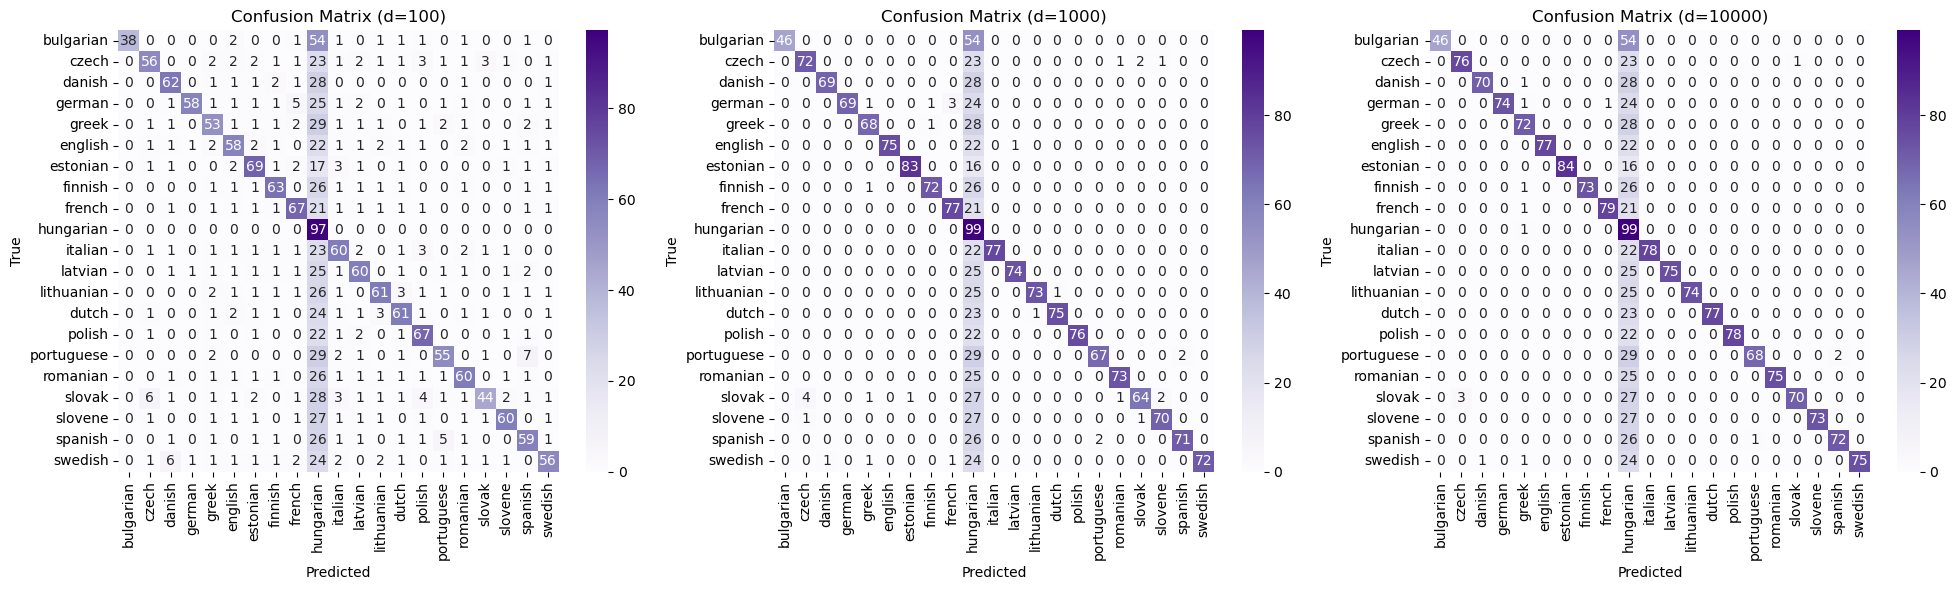

In [14]:
labels = ["bulgarian", "czech", "danish", "german", "greek", "english", "estonian",
          "finnish", "french", "hungarian", "italian", "latvian", "lithuanian",
          "dutch", "polish", "portuguese", "romanian", "slovak", "slovene",
          "spanish", "swedish"]

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, (d, _, _, _, _, cm) in enumerate(results_hdc):
    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Convert to percentages
    cm_percentage = cm_normalized * 100
    
    # Plot the confusion matrix with percentages
    sns.heatmap(cm_percentage, ax=axes[i], annot=True, fmt='.0f', cmap='Purples', xticklabels=labels, yticklabels=labels)
    axes[i].set_title(f'Confusion Matrix (d={d})')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

## Custom Text Test ##

In [15]:
# Select the best model (highest accuracy)
best_model = max(results_hdc, key=lambda x: x[3])
print(f"Best model: d={best_model[0]}, Accuracy: {best_model[3]:.4f}, F1-score: {best_model[4]:.4f}")
 
# Use the best model for further analysis or predictions
best_clf, best_encoder = best_model[1], best_model[2]


Best model: d=10000, Accuracy: 0.7456, F1-score: 0.8200


In [16]:
def classify_custom_text(text, encoder, clf, label_encoder):
    """
    Classify custom text using the trained encoder and classifier.
    """
    preprocessed_text = preprocess_text(text)
    encoded_text = encoder.encode(preprocessed_text)
    prediction = clf.predict([encoded_text])
    predicted_label = label_encoder.inverse_transform(prediction)
    return predicted_label[0]

In [17]:
# Example of classifying custom text (1)
custom_text = "Jag ska dricka en kopp te till frukost, vill du ha?" # swedish
predicted_language = classify_custom_text(custom_text, encoder, clf, label_encoder)
print(f"The predicted language for the custom text is: {predicted_language}")

The predicted language for the custom text is: swedish


In [18]:
# Example of classifying custom text (3)
custom_text = "Cómo te sentís hoy que je te vois un peu triste?" # mix spanish and french
predicted_language = classify_custom_text(custom_text, encoder, clf, label_encoder)
print(f"The predicted language for the custom text is: {predicted_language}")

The predicted language for the custom text is: french


## SOM Class Definition ##

In [19]:
class SOM:
    """
    Self-Organizing Map (SOM) implementation.

    This class implements a SOM, which is an unsupervised learning method to produce
    a low-dimensional representation of the input space of the training samples.
    """

    def __init__(self, input_dim, grid_size, learning_rate=0.1, sigma=None):
        """
        Initialize the SOM.

        Args:
            input_dim (int): The dimensionality of the input data.
            grid_size (int): The size of the SOM grid (grid_size x grid_size).
            learning_rate (float, optional): Initial learning rate. Defaults to 0.1.
            sigma (float, optional): Initial radius of the neighborhood function. 
                                     If None, it's set to half the grid size.
        """
        self.input_dim = input_dim
        self.grid_size = grid_size
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else grid_size / 2 # Set to 50% the grid size
        # Initialize weights with small random values
        self.weights = np.random.randn(grid_size, grid_size, input_dim) * 0.1

    def _decay_function(self, initial_value, iteration, max_iter):
        """
        Compute the decay of a value over iterations.

        Args:
            initial_value (float): The initial value to decay.
            iteration (int): The current iteration.
            max_iter (int): The maximum number of iterations.

        Returns:
            float: The decayed value.
        """
        return initial_value * np.exp(-iteration / max_iter)

    def _neighborhood_function(self, distance, sigma):
        """
        Compute the neighborhood function.

        Args:
            distance (float): The distance from the BMU.
            sigma (float): The current neighborhood radius.

        Returns:
            float: The neighborhood function value.
        """
        return np.exp(-0.5 * (distance / sigma)**2)

    def find_bmu(self, x):
        """
        Find the Best Matching Unit (BMU) for a given input vector.

        Args:
            x (numpy.array): The input vector.

        Returns:
            tuple: The (row, col) coordinates of the BMU in the SOM grid.
        """
        x = np.atleast_2d(x) # To ensure that the rest of the code, which expects x to be a 2D arr., works correctly.
        # Compute the squared Euclidean distance between x and all neurons
        distances = np.sum((self.weights - x[:, np.newaxis, np.newaxis, :])**2, axis=-1)
        # Find the index of the neuron with the smallest distance
        return np.unravel_index(np.argmin(distances.reshape(-1)), (self.grid_size, self.grid_size))

    def train(self, data, epochs=100):
        """
        Train the SOM on the input data.

        Args:
            data (numpy.array): The training data.
            epochs (int, optional): The number of training epochs. Defaults to 100.
        """
        data = np.atleast_2d(data)
        max_iter = len(data) * epochs
        for epoch in range(epochs):
            for i, x in enumerate(data):
                iteration = epoch * len(data) + i
                bmu = self.find_bmu(x)
                # Update learning rate and sigma
                self.learning_rate = self._decay_function(self.initial_learning_rate, iteration, max_iter)
                self.sigma = max(self._decay_function(self.sigma, iteration, max_iter), 1e-10)
                
                # Create a grid of coordinates
                rows, cols = np.indices((self.grid_size, self.grid_size))
                
                # Calculate squared distances from each point to the BMU
                distance_sq = (rows - bmu[0])**2 + (cols - bmu[1])**2
                
                # Compute the neighborhood function
                influence = self._neighborhood_function(np.sqrt(distance_sq), self.sigma)
                influence = influence.reshape(self.grid_size, self.grid_size, 1)
                
                # Update weights
                self.weights += self.learning_rate * influence * (x - self.weights)

    def predict(self, data):
        """
        Find the BMU for each input vector in the data.

        Args:
            data (numpy.array): The input data to map to the SOM.

        Returns:
            numpy.array: An array of BMU coordinates for each input vector.
        """
        return np.array([self.find_bmu(x) for x in np.atleast_2d(data)])

## HDC -- Run Experiments ##
### run above --> results saved in 'results_hdc' ### 

## SOM -- Run Experiments ##

In [20]:
def evaluate_SOM(y_true, y_pred):
    """
    Compute accuracy and weighted F1-score for SOM predictions.
    
    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels, where -1 indicates an invalid prediction.

    Returns:
        tuple: A tuple containing (accuracy, f1-score).
    """
    # Filter out invalid predictions (those with -1 label)
    valid_indices = y_pred != -1
    y_true_filtered = y_true[valid_indices]
    y_pred_filtered = y_pred[valid_indices]
    
    # Calculate accuracy on valid predictions
    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
    
    # Calculate weighted F1-score on valid predictions
    f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted') # (again) For multi-class classification problems
    
    return accuracy, f1

def run_som_experiment(X_train, X_test, y_train, y_test, grid_sizes, k_values):
    results = []  # List to store the results
    
    # Convert text data to bigram statistics using character-level bigrams
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
    X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
    X_test_vectorized = vectorizer.transform(X_test).toarray()
    
    # Normalize the bigram vectors using L2 normalization (==> all vectors are of equal length)
    X_train_normalized = normalize(X_train_vectorized, norm='l2', axis=1)
    X_test_normalized = normalize(X_test_vectorized, norm='l2', axis=1)
    
    input_dim = X_train_normalized.shape[1]  # Define the dimensionality of the input data
    
    for k in k_values:
        # Simple random projection to reduce the dimensionality to d - used to preserve thedistances 
        # between points in HD space when projecting them into a lower-dimensional space
        projection_matrix = np.random.randn(input_dim, k)
        X_train_projected = X_train_normalized.dot(projection_matrix)
        X_test_projected = X_test_normalized.dot(projection_matrix)
        
        # Normalize again after the projection because the projection can generate vectors of different leghts
        X_train_projected = normalize(X_train_projected, norm='l2', axis=1)
        X_test_projected = normalize(X_test_projected, norm='l2', axis=1)
        
        for grid_size in tqdm(grid_sizes, desc=f"Grid Sizes (d={k})"):
            som = SOM(input_dim=k, grid_size=grid_size)  # Init the SOM with the current grid size
            som.train(X_train_projected, epochs=100)  # Train the SOM with 100 epochs
            
            y_train_som = som.predict(X_train_projected)  # Predict the BMUs for the training data
            y_test_som = som.predict(X_test_projected)  # Predict the BMUs for the test data
            
            # Map each BMU to the most common label in the training data
            som_label_map = {}
            for i, label in enumerate(y_train):
                bmu = tuple(y_train_som[i])
                if bmu not in som_label_map:
                    som_label_map[bmu] = []
                som_label_map[bmu].append(label)
            
            # Assign the most frequent label to each BMU in the map
            for key in som_label_map:
                som_label_map[key] = max(set(som_label_map[key]), key=som_label_map[key].count)
            
            # Map the BMUs predicted on the test data to their corresponding labels
            y_test_mapped = np.array([som_label_map.get(tuple(pred), -1) for pred in y_test_som])

            # Evaluate the performance of the model
            accuracy = np.mean(y_test_mapped == y_test) 
            f1 = f1_score(y_test, y_test_mapped, average='weighted') 
            results.append((k, grid_size, accuracy, f1))  # Store the results for this configuration
            print(f"d={k}, Grid Size={grid_size}, Accuracy: {accuracy:.3f}, F1-score: {f1:.3f}")
            
            # Additional logging
            unique_labels = len(set(y_test_mapped))  # Count the number of unique labels predicted
            most_common = Counter(y_test_mapped).most_common(1)[0]  # Find the most common predicted label (was intrigued)
            print(f"  Unique labels predicted: {unique_labels}")
            print(f"  Most common prediction: {most_common}")
    
    return results  # Return the collected results for all ks and grid_sizes


In [21]:
# SOM experiment
grid_sizes = range(2, 21, 2)
k_values = [100, 300, 500, 729] #For bigrams - max 27*27
som_results = run_som_experiment(X_train, X_test, y_train_encoded, y_test_encoded, grid_sizes, k_values)

Grid Sizes (d=100):  10%|█         | 1/10 [03:18<29:44, 198.26s/it]

d=100, Grid Size=2, Accuracy: 0.079, F1-score: 0.027
  Unique labels predicted: 4
  Most common prediction: (0, 5195)


Grid Sizes (d=100):  20%|██        | 2/10 [07:04<28:37, 214.72s/it]

d=100, Grid Size=4, Accuracy: 0.228, F1-score: 0.179
  Unique labels predicted: 10
  Most common prediction: (19, 6858)


Grid Sizes (d=100):  30%|███       | 3/10 [11:24<27:26, 235.26s/it]

d=100, Grid Size=6, Accuracy: 0.393, F1-score: 0.393
  Unique labels predicted: 18
  Most common prediction: (19, 5557)


Grid Sizes (d=100):  40%|████      | 4/10 [16:35<26:31, 265.28s/it]

d=100, Grid Size=8, Accuracy: 0.573, F1-score: 0.607
  Unique labels predicted: 21
  Most common prediction: (19, 5465)


Grid Sizes (d=100):  50%|█████     | 5/10 [22:37<24:59, 300.00s/it]

d=100, Grid Size=10, Accuracy: 0.645, F1-score: 0.696
  Unique labels predicted: 21
  Most common prediction: (19, 5361)


Grid Sizes (d=100):  60%|██████    | 6/10 [29:37<22:43, 340.85s/it]

d=100, Grid Size=12, Accuracy: 0.652, F1-score: 0.703
  Unique labels predicted: 21
  Most common prediction: (19, 5357)


Grid Sizes (d=100):  70%|███████   | 7/10 [38:22<20:03, 401.04s/it]

d=100, Grid Size=14, Accuracy: 0.654, F1-score: 0.707
  Unique labels predicted: 22
  Most common prediction: (19, 5441)


Grid Sizes (d=100):  80%|████████  | 8/10 [48:39<15:39, 469.79s/it]

d=100, Grid Size=16, Accuracy: 0.655, F1-score: 0.707
  Unique labels predicted: 22
  Most common prediction: (19, 5458)


Grid Sizes (d=100):  90%|█████████ | 9/10 [1:00:56<09:13, 553.28s/it]

d=100, Grid Size=18, Accuracy: 0.655, F1-score: 0.708
  Unique labels predicted: 22
  Most common prediction: (19, 5455)


Grid Sizes (d=100): 100%|██████████| 10/10 [1:14:59<00:00, 449.92s/it]

d=100, Grid Size=20, Accuracy: 0.656, F1-score: 0.710
  Unique labels predicted: 22
  Most common prediction: (19, 5537)



Grid Sizes (d=300):  10%|█         | 1/10 [03:29<31:29, 209.94s/it]

d=300, Grid Size=2, Accuracy: 0.083, F1-score: 0.029
  Unique labels predicted: 4
  Most common prediction: (19, 5237)


Grid Sizes (d=300):  20%|██        | 2/10 [07:49<31:55, 239.40s/it]

d=300, Grid Size=4, Accuracy: 0.226, F1-score: 0.181
  Unique labels predicted: 11
  Most common prediction: (19, 6713)


Grid Sizes (d=300):  30%|███       | 3/10 [13:34<33:32, 287.45s/it]

d=300, Grid Size=6, Accuracy: 0.393, F1-score: 0.387
  Unique labels predicted: 18
  Most common prediction: (19, 5657)


Grid Sizes (d=300):  40%|████      | 4/10 [22:32<38:38, 386.37s/it]

d=300, Grid Size=8, Accuracy: 0.605, F1-score: 0.647
  Unique labels predicted: 21
  Most common prediction: (19, 5436)


Grid Sizes (d=300):  50%|█████     | 5/10 [35:50<44:33, 534.68s/it]

d=300, Grid Size=10, Accuracy: 0.654, F1-score: 0.707
  Unique labels predicted: 21
  Most common prediction: (19, 5428)


Grid Sizes (d=300):  60%|██████    | 6/10 [55:02<49:38, 744.64s/it]

d=300, Grid Size=12, Accuracy: 0.656, F1-score: 0.709
  Unique labels predicted: 22
  Most common prediction: (19, 5417)


Grid Sizes (d=300):  70%|███████   | 7/10 [1:13:14<42:54, 858.27s/it]

d=300, Grid Size=14, Accuracy: 0.655, F1-score: 0.708
  Unique labels predicted: 21
  Most common prediction: (19, 5401)


Grid Sizes (d=300):  80%|████████  | 8/10 [1:33:38<32:29, 974.70s/it]

d=300, Grid Size=16, Accuracy: 0.657, F1-score: 0.709
  Unique labels predicted: 22
  Most common prediction: (19, 5424)


Grid Sizes (d=300):  90%|█████████ | 9/10 [1:58:20<18:53, 1133.29s/it]

d=300, Grid Size=18, Accuracy: 0.656, F1-score: 0.709
  Unique labels predicted: 22
  Most common prediction: (19, 5485)


Grid Sizes (d=300): 100%|██████████| 10/10 [2:43:16<00:00, 979.69s/it] 

d=300, Grid Size=20, Accuracy: 0.657, F1-score: 0.710
  Unique labels predicted: 22
  Most common prediction: (19, 5469)



Grid Sizes (d=500):  10%|█         | 1/10 [04:38<41:45, 278.35s/it]

d=500, Grid Size=2, Accuracy: 0.085, F1-score: 0.029
  Unique labels predicted: 4
  Most common prediction: (0, 5184)


Grid Sizes (d=500):  20%|██        | 2/10 [09:46<39:26, 295.83s/it]

d=500, Grid Size=4, Accuracy: 0.209, F1-score: 0.169
  Unique labels predicted: 13
  Most common prediction: (0, 4911)


Grid Sizes (d=500):  30%|███       | 3/10 [16:46<41:06, 352.41s/it]

d=500, Grid Size=6, Accuracy: 0.413, F1-score: 0.406
  Unique labels predicted: 17
  Most common prediction: (19, 5450)


Grid Sizes (d=500):  40%|████      | 4/10 [27:17<46:15, 462.57s/it]

d=500, Grid Size=8, Accuracy: 0.610, F1-score: 0.662
  Unique labels predicted: 21
  Most common prediction: (19, 5201)


Grid Sizes (d=500):  50%|█████     | 5/10 [40:19<48:07, 577.60s/it]

d=500, Grid Size=10, Accuracy: 0.643, F1-score: 0.694
  Unique labels predicted: 22
  Most common prediction: (19, 5487)


Grid Sizes (d=500):  60%|██████    | 6/10 [58:51<50:37, 759.48s/it]

d=500, Grid Size=12, Accuracy: 0.654, F1-score: 0.709
  Unique labels predicted: 22
  Most common prediction: (19, 5564)


Grid Sizes (d=500):  70%|███████   | 7/10 [1:21:03<47:19, 946.63s/it]

d=500, Grid Size=14, Accuracy: 0.655, F1-score: 0.706
  Unique labels predicted: 22
  Most common prediction: (19, 5381)


Grid Sizes (d=500):  80%|████████  | 8/10 [1:52:10<41:19, 1239.72s/it]

d=500, Grid Size=16, Accuracy: 0.655, F1-score: 0.708
  Unique labels predicted: 22
  Most common prediction: (19, 5462)


Grid Sizes (d=500):  90%|█████████ | 9/10 [2:28:52<25:40, 1540.30s/it]

d=500, Grid Size=18, Accuracy: 0.657, F1-score: 0.710
  Unique labels predicted: 22
  Most common prediction: (19, 5453)


Grid Sizes (d=500): 100%|██████████| 10/10 [3:19:45<00:00, 1198.59s/it]

d=500, Grid Size=20, Accuracy: 0.657, F1-score: 0.709
  Unique labels predicted: 22
  Most common prediction: (19, 5458)



Grid Sizes (d=729):  10%|█         | 1/10 [03:39<32:57, 219.75s/it]

d=729, Grid Size=2, Accuracy: 0.083, F1-score: 0.029
  Unique labels predicted: 4
  Most common prediction: (0, 5246)


Grid Sizes (d=729):  20%|██        | 2/10 [09:32<39:45, 298.25s/it]

d=729, Grid Size=4, Accuracy: 0.207, F1-score: 0.169
  Unique labels predicted: 12
  Most common prediction: (0, 4693)


Grid Sizes (d=729):  30%|███       | 3/10 [18:52<48:43, 417.61s/it]

d=729, Grid Size=6, Accuracy: 0.360, F1-score: 0.352
  Unique labels predicted: 17
  Most common prediction: (19, 5557)


Grid Sizes (d=729):  40%|████      | 4/10 [31:37<55:28, 554.71s/it]

d=729, Grid Size=8, Accuracy: 0.586, F1-score: 0.632
  Unique labels predicted: 21
  Most common prediction: (19, 5177)


Grid Sizes (d=729):  50%|█████     | 5/10 [50:17<1:03:12, 758.57s/it]

d=729, Grid Size=10, Accuracy: 0.654, F1-score: 0.708
  Unique labels predicted: 21
  Most common prediction: (19, 5448)


Grid Sizes (d=729):  60%|██████    | 6/10 [1:15:29<1:07:39, 1014.82s/it]

d=729, Grid Size=12, Accuracy: 0.654, F1-score: 0.707
  Unique labels predicted: 22
  Most common prediction: (19, 5440)


Grid Sizes (d=729):  70%|███████   | 7/10 [1:50:52<1:08:50, 1376.94s/it]

d=729, Grid Size=14, Accuracy: 0.654, F1-score: 0.708
  Unique labels predicted: 22
  Most common prediction: (19, 5512)


Grid Sizes (d=729):  80%|████████  | 8/10 [2:32:51<58:01, 1740.62s/it]  

d=729, Grid Size=16, Accuracy: 0.657, F1-score: 0.710
  Unique labels predicted: 22
  Most common prediction: (19, 5527)


Grid Sizes (d=729):  90%|█████████ | 9/10 [3:35:35<39:33, 2373.10s/it]

d=729, Grid Size=18, Accuracy: 0.658, F1-score: 0.710
  Unique labels predicted: 22
  Most common prediction: (19, 5432)


Grid Sizes (d=729): 100%|██████████| 10/10 [4:52:30<00:00, 1755.04s/it]

d=729, Grid Size=20, Accuracy: 0.656, F1-score: 0.709
  Unique labels predicted: 22
  Most common prediction: (19, 5450)


In [83]:
all_results = []

In [84]:
for d, clf, encoder, accuracy, f1, cm in results_hdc:
    result_dict = {
        'Method': 'HDC',
        'Grid Size': '',
        'Parameter (d)': d,
        'Accuracy': accuracy,
        'F1-score': f1
    }
    all_results.append(result_dict)

In [78]:
for k, grid_size, accuracy, f1 in som_results:
    result_dict = {
        'Method': 'SOM',
        'Grid Size': grid_size,
        'Parameter (d)': k_values,
        'Accuracy': accuracy,
        'F1-score': f1
    }
    all_results.append(result_dict)

In [94]:
# Combine and display results
results_df = pd.DataFrame(all_results, columns=['Method', 'Grid Size', 'Parameter (d)', 'Accuracy', 'F1-score'])
# print(results_df)

## VISUALIZATION ##

### SOM and HDC - Accuracy vs Grid Size ###

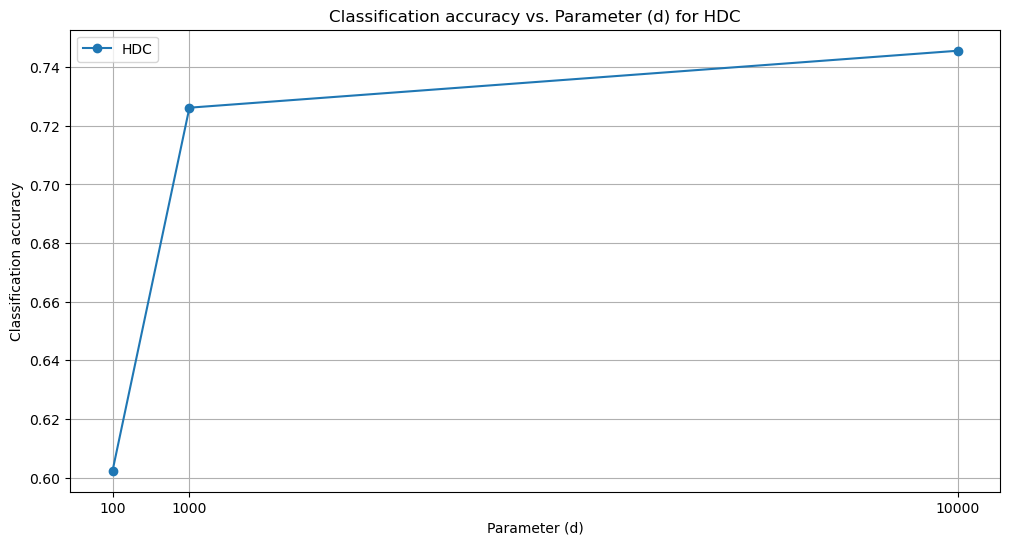

In [98]:
# Figure 1: For Method = 'HDC'
plt.figure(figsize=(12, 6))
df_hdc = results_df[results_df["Method"] == 'HDC']
plt.plot(df_hdc["Parameter (d)"], df_hdc["Accuracy"], label='HDC', marker='o')

plt.xlabel('Parameter (d)')
plt.ylabel('Classification accuracy')
plt.title('Classification accuracy vs. Parameter (d) for HDC')
plt.grid(True)

plt.xticks([100, 1000, 10000])

plt.legend()
plt.show()

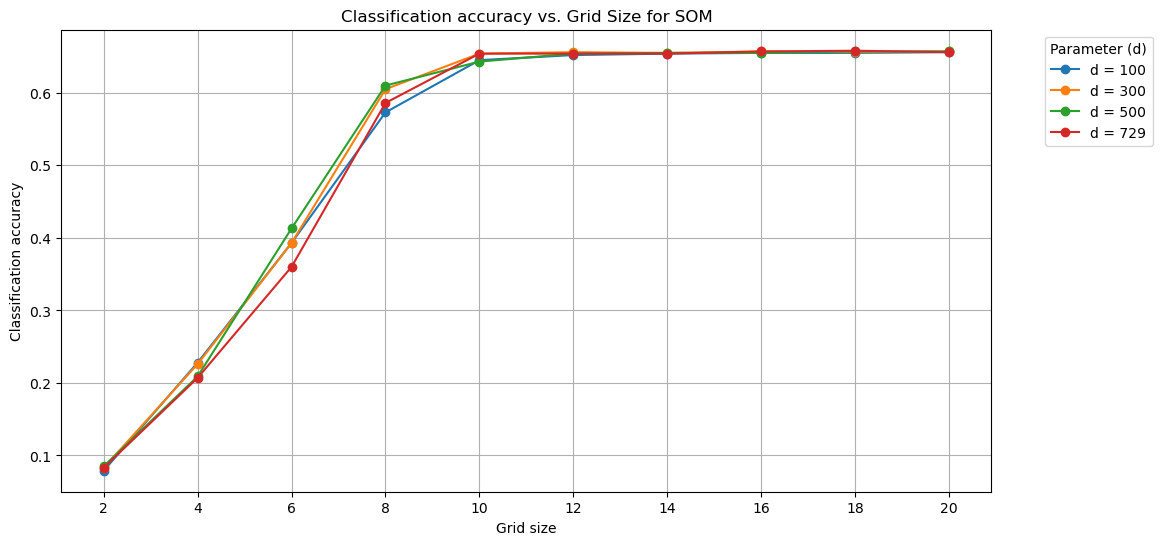

In [99]:
# Figure 2: For Method = 'SOM'
plt.figure(figsize=(12, 6))
df_som = results_df[results_df["Method"] == 'SOM']

for param_d in df_som['Parameter (d)'].unique():
    df_subset = df_som[df_som["Parameter (d)"] == param_d]
    plt.plot(df_subset["Grid Size"], df_subset["Accuracy"], label=f'd = {param_d}', marker='o')

plt.xlabel('Grid size')
plt.ylabel('Classification accuracy')
plt.title('Classification accuracy vs. Grid Size for SOM')
plt.grid(True)

plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

plt.legend(title="Parameter (d)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()